# Read Length

### Story
Read length is an important attribute because it can improve specificity of alignment. Read length has increased over time. Initially most studies used a read length of ~35bp, but as sequencing became cheaper and less error prone read length has increased to 50+ bp. The workflow removes reads that are shorter than <25 bp after trimming. Here I look at how read lengths differs across experiments and identify experiments with short read lengths. Read length can also help inform the technology used for sequencing. Illumina is typically ranges between 36bp to 150bp, while other technologies can go into kilobases.

The vast majority of samples (n=24,677) have a read length between 25-160bp. With most samples having a read length of 51 (single end) or 2x95 (pair end). There are 890 samples that are too short (< 25bp), and 193 samples that are really long (≥ 300 bp).

### Output
* Distribution plot of read lengths separated by Single End and Pair End data. I focus on reads ≤ 160 bp for plots.
* Output table with flags fitting different criteria. `../../output/read_length_downstream_analysis`
    - `flag_too_short` True if the read length < 25 bp
    - `flag_short` True if 25 bp ≤ read length < 45 bp
    - `flag_good` True if 45 bp ≤ read length < 160 bp
    - `flag_long`True if 160 bp ≤ read length < 300 bp
    - `flag_really_long`True if 300 bp ≤ read length


In [3]:
# %load ../start.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 2

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -g

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# Add project library to path
import sys
sys.path.insert(0, '../../lib/python')

# The usual suspects
import os
import numpy as np
import pandas as pd

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('notebook')

# Turn off scientific notation
np.set_printoptions(precision=5, suppress=True)


last updated: 2017-10-05 
Git hash: 6714964c9006c60449cf4e59630ca6f7bf5688e2


In [236]:
# %load ../../bin/load.py
from pymongo import MongoClient
with open('/home/fearjm/Projects/ncbi_remap/output/.mongodb_host', 'r') as fh:
    host = fh.read().strip()
client = MongoClient(host=host, port=27022)
db = client['sra2']
remap = db['remap']
ncbi = db['ncbi']


In [124]:
# Build data frame with read lengths.
se = pd.DataFrame(list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.pre_aln_flags': 'SE',
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
            'read_length': {
                '$cond': [
                    {'$in': ['keep_R2', '$runs.pre_aln_flags']},
                    '$runs.avgReadLen.R2',
                    '$runs.avgReadLen.R1'
                ]
            }
        }
    },
])))

se.set_index(['srx', 'srr'], inplace=True)
se['layout'] = 'SE'

pe = pd.DataFrame(list(remap.aggregate([
    {'$unwind': '$runs'},
    {
        '$match': {
            'runs.pre_aln_flags': 'PE',
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'srr': '$runs.srr',
            'read_length': {
                '$max': [
                    '$runs.avgReadLen.R1',
                    '$runs.avgReadLen.R2'
                ]
            }
        }
    },
])))
pe.set_index(['srx', 'srr'], inplace=True)
pe['layout'] = 'PE'

df = pd.concat([se, pe])

# Convert floats (averages) to an int b/c don't care about decimals.
df['read_length_norm'] = df.read_length.astype(int)

In [277]:
# Create layout masks incase I need to separate by layout.
se = df.layout == 'SE'
pe = df.layout == 'PE'
short = df.read_length_norm <= 160

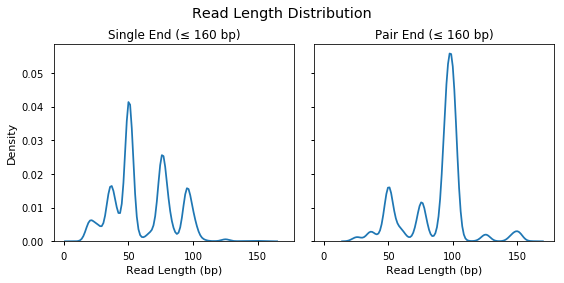

In [281]:
# Plot distribution of SE and PE focus only on samples with read lengths ≤200 bp.
## I found including all samples zoomed the dist out too far to be useful.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=plt.figaspect(1/2), sharex=True, sharey=True)
plt.suptitle('Read Length Distribution')

sns.distplot(df[se & short].read_length_norm, ax=ax1, hist=False)
ax1.set_xlabel('Read Length (bp)')
ax1.set_ylabel('Density')
ax1.set_title('Single End (≤ {} bp)'.format(160))

sns.distplot(df[pe & short].read_length_norm, ax=ax2, hist=False)
ax2.set_xlabel('Read Length (bp)')
ax2.set_ylabel('')
ax2.set_title('Pair End (≤ {} bp)'.format(160))
plt.tight_layout(rect=[0, 0, 1, .95]);

In [206]:
# Summary counts looking at different bins.
print('There are a total of {:,} samples.'.format(df.shape[0]))
df['bin'] = pd.cut(df.read_length_norm, [20, 40, 60, 80, 100, 120, 140, 160, 300, 2000, np.inf], labels=None)
cnts = df.groupby('bin').agg({'read_length_norm': ['min', 'max', 'median', 'count']})
cnts.applymap(lambda x: '{:,.0f}'.format(x))

There are a total of 27,138 samples.


read_length_norm                     
                         min    max median  count
bin                                              
(20, 40]                  21     40     36  3,845
(40, 60]                  41     60     51  8,066
(60, 80]                  61     80     76  5,488
(80, 100]                 81    100     95  6,552
(100, 120]               101    120    101  1,382
(120, 140]               123    140    125    221
(140, 160]               141    160    151    239
(160, 300]               164    298    240    344
(300, 2000]              395  1,852    536    171
(2000, inf]            2,097  6,340  4,026     22

In [254]:
# What instruments are the large fragments from
srx = df[(df.read_length_norm > 160)].index.get_level_values(0).tolist()

dd = pd.DataFrame(list(ncbi.aggregate([
    {
        '$match': {
            '_id': {'$in': srx}
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'library_strategy': '$sra.experiment.library_strategy',
            'instrument_model': '$sra.experiment.instrument_model',
        }
    }
])))

print('Samples with read lengths > 160 bp are from these machines.')
dd.instrument_model.value_counts().sort_index().to_frame().rename(
    columns={
        'instrument_model': 'count'
    }
)

Samples with read lengths > 160 bp are from these machines.


,count
454 GS,1
454 GS 20,4
454 GS FLX,29
454 GS FLX Titanium,39
454 GS FLX+,1
454 GS Junior,250
Illumina MiSeq,19
Ion Torrent PGM,3
MinION,1
PacBio RS,1


In [283]:
# Create output table
output = pd.DataFrame(index=df.index)

cutoffs = {
    'too_short': lambda x: x < 25,
    'short': lambda x: (x >= 25) & (x < 45),
    'good': lambda x: (x >= 45) & (x < 160),
    'long': lambda x: (x >= 160) & (x < 300),
    'really_long': lambda x: (x >= 300),
}

output['flag_too_short'] = False
output.loc[list(map(cutoffs['too_short'], df.read_length_norm)), 'flag_too_short'] = True

output['flag_short'] = False
output.loc[list(map(cutoffs['short'], df.read_length_norm)), 'flag_short'] = True

output['flag_good'] = False
output.loc[list(map(cutoffs['good'], df.read_length_norm)), 'flag_good'] = True

output['flag_long'] = False
output.loc[list(map(cutoffs['long'], df.read_length_norm)), 'flag_long'] = True

output['flag_really_long'] = False
output.loc[list(map(cutoffs['really_long'], df.read_length_norm)), 'flag_really_long'] = True

# Output summary table
output.to_pickle('../../output/read_length_downstream_analysis')
# Quick summary table
output.sum().to_frame().applymap(lambda x: '{:,}'.format(x))

,0
flag_too_short,890
flag_short,"4,104"
flag_good,"21,605"
flag_long,346
flag_really_long,193


In [275]:
# counts for summary
num_samples = '{:,}'.format(df.shape[0])
num_lt_160 = '{:,}'.format(output.flag_short.sum() + output.flag_good.sum())
min_read = '{:,}'.format(df.read_length_norm.min())
min_sample = '->'.join(df.read_length_norm.argmin())
max_read = '{:,}'.format(df.read_length_norm.max())
max_sample = '->'.join(df.read_length_norm.argmax())
se_mode = df[se].read_length_norm.mode().values[0]
pe_mode = df[pe].read_length_norm.mode().values[0]

### Summary

There is a large spread of read lengths in SRA. Of the {{num_samples}} samples, the majority (n={{num_le_160}}) have reads between 25-160bp. The most frequent read length in Single End data was {{se_mode}} bp, while the most frequent read length in Pair End data was {{pe_mode}} bp. Sample {{min_sample}} had the minimum read length of {{min_read}}, while {{max_sample}} had the maximum read length of {{max_read}}.

If we look at samples with read lengths greater than 160 bp are mostly from the *454 GS Junior* or other 454 machine. 

In [282]:
output.head()

,,flag_too_short,flag_short,flag_good,flag_long,flag_really_long
srx,srr,,,,,
SRX2556775,SRR5251041,False,False,True,False,False
SRX2556774,SRR5251040,False,False,True,False,False
SRX2556773,SRR5251039,False,False,True,False,False
SRX2556772,SRR5251038,False,False,True,False,False
SRX2556771,SRR5251037,False,False,True,False,False
